In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors

# 운영체제에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스용 나눔폰트 설치 필요

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [25]:
df = pd.read_csv('data/student.csv', encoding='utf-8')

df.shape

(1200, 12)

In [27]:
df.columns

Index(['모집년도', '전형구분', '전형유형', '지원학과(부)', '출신고교계열', '학생부_평균등급', '학생부_국어등급',
       '학생부_영어등급', '학생부_수학등급', '수능_백분위', '고교소재국가', '최종합격여부'],
      dtype='object')

In [29]:
# 2. 기본 전처리
# '최종합격여부'를 1/0으로 변환
df['최종합격여부'] = df['최종합격여부'].map({'Y':1, 'N':0})

# 숫자형 변환
num_cols = ['학생부_평균등급', '학생부_국어등급', '학생부_영어등급',
            '학생부_수학등급', '수능_백분위']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# 결측치는 평균으로 대체
df.fillna(df.mean(numeric_only=True), inplace=True)
df.shape

(1200, 12)

In [31]:
# 3. 연도별 합격선 분석 (최종합격자 중 최소 수능 백분위)
cutoff = (
    df[df['최종합격여부'] == 1]
    .groupby('모집년도')['수능_백분위']
    .min()
    .reset_index()
    .rename(columns={'수능_백분위':'cutoff_score'})
)

print("연도별 합격선 (최저 수능 백분위):")
print(cutoff)

연도별 합격선 (최저 수능 백분위):
   모집년도  cutoff_score
0  2020            51
1  2021            50
2  2022            50
3  2023            50
4  2024            50


<Figure size 1200x600 with 0 Axes>

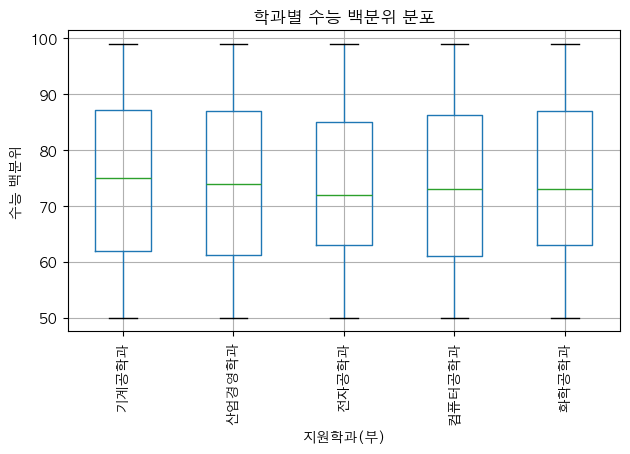

In [35]:
# 4. 학과별 성적분포 시각화 (수능 백분위)
plt.figure(figsize=(12,6))
df.boxplot(column='수능_백분위', by='지원학과(부)', rot=90)
plt.title('학과별 수능 백분위 분포')
plt.suptitle('')
plt.ylabel('수능 백분위')
plt.tight_layout()
plt.show()

In [33]:

# 5. 최종합격 여부 분류모델
features = num_cols
X = df[features]
y = df['최종합격여부']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n분류 모델 성능:")
print(classification_report(y_test, y_pred, target_names=['불합격','합격']))



분류 모델 성능:
              precision    recall  f1-score   support

         불합격       0.46      0.40      0.43        89
          합격       0.67      0.72      0.70       151

    accuracy                           0.60       240
   macro avg       0.57      0.56      0.56       240
weighted avg       0.59      0.60      0.60       240



In [37]:
# 6. 유사조건 합격자 검색기
nn = NearestNeighbors(n_neighbors=6)
nn.fit(X)

def find_similar(idx, n=5):
    dists, idxs = nn.kneighbors(X.iloc[[idx]], n_neighbors=n+1)
    similar = idxs[0][1:]
    return df.iloc[similar]

# 예시: 0번 인덱스 지원자와 유사한 5명
print("\n0번 지원자와 유사한 합격자:")
print(find_similar(0))


0번 지원자와 유사한 합격자:
      모집년도 전형구분   전형유형 지원학과(부) 출신고교계열  학생부_평균등급  학생부_국어등급  학생부_영어등급  학생부_수학등급  \
1053  2020   수시   교과전형   기계공학과    예체능       4.1         3         4         4   
282   2020   수시   교과전형  컴퓨터공학과    예체능       2.8         3         5         4   
585   2024   수시  특기자전형   전자공학과     이과       3.9         2         6         3   
84    2020   정시  특기자전형   화학공학과     문과       2.3         3         3         3   
864   2022   수시   논술전형   기계공학과    예체능       1.9         1         4         4   

      수능_백분위 고교소재국가  최종합격여부  
1053      80     미국       0  
282       79     중국       0  
585       79     중국       0  
84        78     미국       0  
864       79     미국       0  
